This has code from online examples with landlab
see other rain_sample_topo file for a more integrated rain and overland flow model

In [441]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 

from random import randint
## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder
from landlab.components import ExponentialWeatherer
from landlab.components import DepthDependentDiffuser
from landlab.components import SpatialPrecipitationDistribution
from landlab.components import OverlandFlow
from landlab.utils.flow__distance import calculate_flow__distance

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
from landlab.io import write_esri_ascii 

%matplotlib inline

101
None


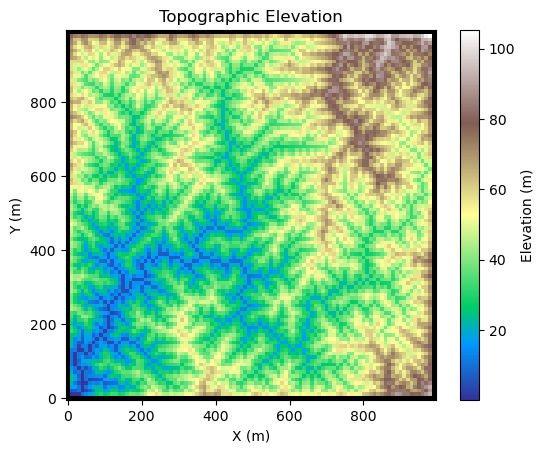

In [442]:
ncols = 100
nrows = 100
cellsize = 10

#mg = RasterModelGrid()
#Set directory paths to retrieve the asc file
#path_project = r"C:/Users/gsbir/Documents/EES_393/Export/" # add the path to the asc file    #this should access my H drive
topo_dem = "sample_topo2_topographic__elevation.txt" #the name of the ascii file
#soil_dem = "sample_topo2_soil__depth.txt"
#bedrock_dem = "sample_topo2_bedrock__elevation.txt"
topo_path = topo_dem
#soil_path = path_project + soil_dem
#bedrock_path = path_project + bedrock_dem

#now read the header of the asc file (where there is ncols nrows cell size and nodata value) into the string variable dem_header
topo_header = read_asc_header(open(topo_path, 'r'))
#soil_header = read_asc_header(open(soil_path, 'r'))
#bedrock_header = read_asc_header(open(bedrock_path, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(topo_path, name = 'topographic__elevation', halo = 0)
#(mg, x) = read_esri_ascii(soil_path, name= 'soil__depth', halo = 1)
#(mg, y) = read_esri_ascii(bedrock_path, name= 'bedrock__elevation', halo = 1)

#set the watershed boundary condition and the function returns a integer which is the outlet_id so this is set equal to a variable so we can view this
#outlet_id = mg.set_watershed_boundary_condition(z, nodata_value = -9999, return_outlet_id=True)


#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)#Close all model boundary edges


#find min elevation
open_nodes = mg.core_nodes
min_topo = mg['node']['topographic__elevation'].argmin()

min_topo_ID = open_nodes[min_topo]

print(min_topo_ID)


#outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999.)
outlet_id = mg.set_watershed_boundary_condition_outlet_id(min_topo_ID, mg['node']['topographic__elevation'], -9999)
#This should find your outlet node automatically and outlet_id will be empty if a single outlet was not found

print(outlet_id) #prints out the outlet_id
outlet_id = min_topo_ID
#print(mg.at_node.keys()) #Shows the node attributes

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

#imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue') #creates a graph showing the red and the closed boundaries are set to blue, black is the landscape and white is the outlet ID (cannot see it at this level)

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
#mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

In [443]:
#Parameters for SPACE and Fastscape
K_sed = 0.0001
K_sp = 0.001
K_br = 0.0001
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0
#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8') 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)


fa.run_one_step()
    #fr.run_one_step()    
df.map_depressions()
       
fsc.run_one_step(1)




profiler = ChannelProfiler(mg,number_of_watersheds=1,minimum_channel_threshold=0,main_channel_only=True)
profiler.run_one_step()
profiler.data_structure.keys() #is [101]
profiler.data_structure[101].keys()
profiler.data_structure[101][(101,9687)]["ids"]


array([ 101,  102,  103,  204,  304,  404,  504,  604,  704,  803,  902,
       1002, 1102, 1202, 1303, 1304, 1205, 1306, 1406, 1507, 1608, 1709,
       1810, 1911, 2011, 2111, 2211, 2312, 2411, 2511, 2612, 2713, 2814,
       2915, 2916, 3017, 3117, 3218, 3219, 3220, 3321, 3421, 3520, 3620,
       3721, 3822, 3723, 3824, 3925, 3926, 3927, 3828, 3829, 3830, 3731,
       3632, 3633, 3734, 3735, 3836, 3837, 3838, 3739, 3740, 3741, 3642,
       3643, 3744, 3745, 3746, 3647, 3548, 3448, 3349, 3249, 3149, 3048,
       2947, 2846, 2747, 2648, 2549, 2448, 2447, 2346, 2247, 2147, 2048,
       1949, 1950, 1951, 2052, 1953, 1954, 1855, 1756, 1657, 1558, 1559,
       1460, 1361, 1462, 1563, 1664, 1764, 1864, 1965, 2065, 2165, 2266,
       2366, 2465, 2565, 2665, 2766, 2767, 2768, 2669, 2770, 2871, 2972,
       2973, 3074, 3175, 3076, 3077, 3178, 3279, 3180, 3281, 3382, 3481,
       3581, 3681, 3781, 3880, 3981, 4081, 4180, 4281, 4381, 4482, 4583,
       4584, 4585, 4686, 4687, 4588, 4589, 4690, 47

In [444]:
#ADDING REST OF THE FIELDS
#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 2  #Set 2 m of initial soil depth at core nodes

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"] - mg.at_node['soil__depth']
#mg.at_node["bedrock__elevation"][:] -= mg.at_node['soil__depth']

mg.at_node['bedrock__elevation'][outlet_id] = 0
mg.at_node['topographic__elevation'][outlet_id] = 0
mg.at_node['soil__depth'][outlet_id] = 0
#Add field 'bedrock__elevation' to the grid
mg.add_zeros('surface_water__depth', at='node')
print(outlet_id)


101


Setting Up Rain and Overland Flow Parameters

In [445]:
of = OverlandFlow(mg, steep_slopes=True)
rain = SpatialPrecipitationDistribution(mg, number_of_years=1)
#storm_t = 1.5 #durration of a storm in hr
#interstorm_t = 8 #time between storms in hr
rain.total_time = 10 #this is for the rain.yield_storms (hr)
of_total_time = 3600 * 8#my own variable for how long overland flow runs in (s) -> 3600 s in 1 h



use precipitation component

the following code created a series of random storm events ( diff amt of storms each iteration )
- each plot produced is one storms' rainfall

11.7984474572
10


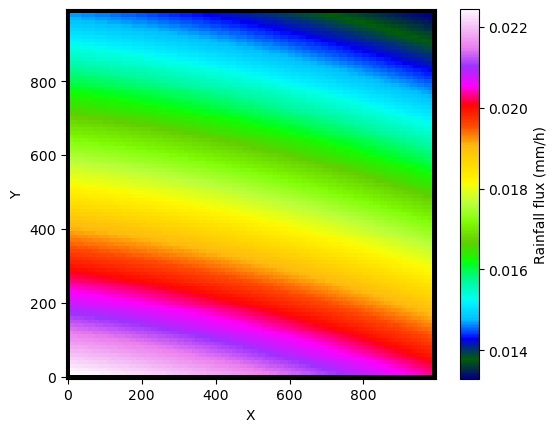

31.296082776
10


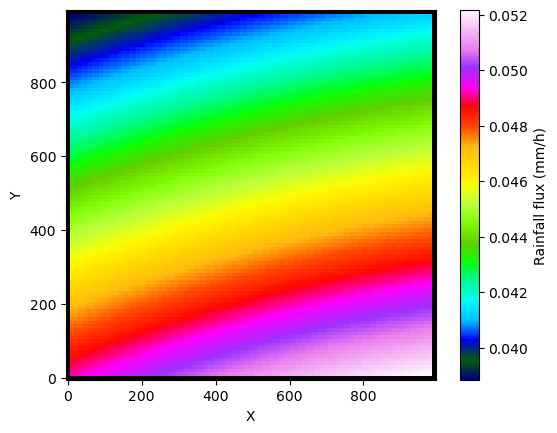

33.5110638085
10


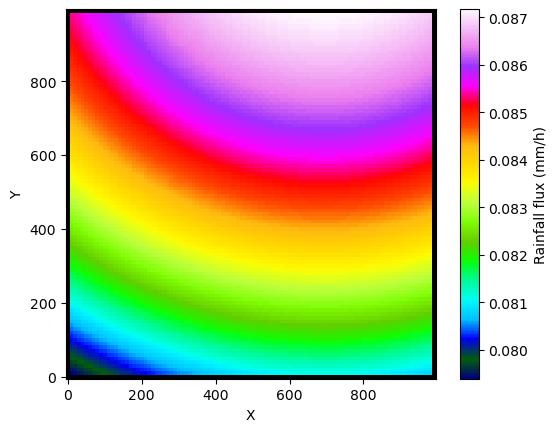

In [446]:

np.random.seed(randint(0, 100)) 

# get the storm simulator to provide a storm

storm_time_data = []
interstorm_time_data = []
storm_amt_data = []
x = 1 #to keep track of each iteration of loop


#this is running for a year
for (storm_t, interstorm_t) in rain.yield_storms(style="whole_year"):  # storm lengths in hrs
    
    storm_time_data.append(storm_t)
    interstorm_time_data.append(interstorm_t*.041)
    storm_amt_data.append(x)
    mg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    mg.at_node['rainfall__flux'] *= 2.0  # to make the storm heavier
    print(rain.median_total_rainfall_this_year)
    print(rain.total_time)
    plt.figure()# plot up this storm
    imshow_grid(mg, 'rainfall__flux', cmap='gist_ncar', colorbar_label='Rainfall flux (mm/h)')
    plt.show()
    x+=1

PLOT OVERALL PRECIPITATION TIME VS. STORM LENGTH

each dot on the graph corresponds to a rainflux plot above

[1.3425432787446565, 0.85690177767021569, 0.052431513088132417]


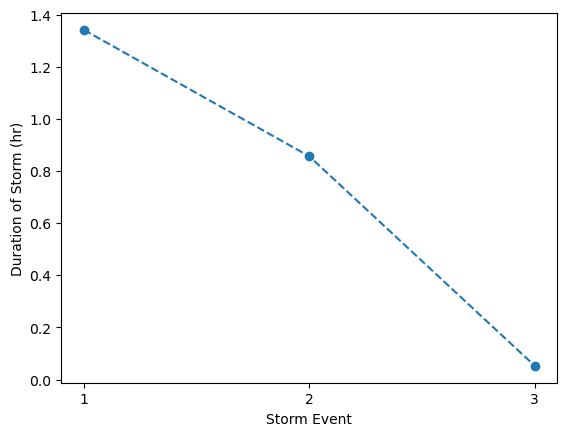

In [447]:
#show graphs of storm time and interstorm data
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()
plot.plot(storm_amt_data, storm_time_data,linestyle='--', marker='o')
plt.xlabel("Storm Event")
plt.ylabel("Duration of Storm (hr)")
plt.xticks(np.arange(1,x,1))
print(storm_time_data)
total_t_check = sum(storm_time_data)

PLOT OVERALL PRECIPITATION TIME VS. INTERSTORM TIME

[100.08468828260625, 50.67233447008072, 208.31065030796341]
361.31954963


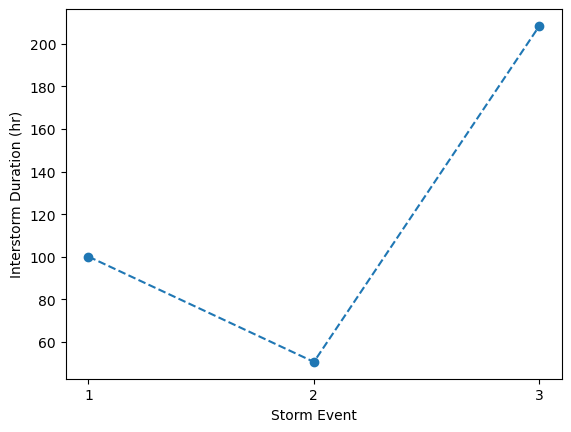

In [448]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()
plot.plot(storm_amt_data, interstorm_time_data,linestyle='--', marker='o')
plt.xlabel("Storm Event")
plt.ylabel("Interstorm Duration (hr)")
plt.xticks(np.arange(1,x,1))
print(interstorm_time_data)
total_t_check += sum(interstorm_time_data)
print(total_t_check)

In [449]:
outlet_node_to_sample = 304
outlet_link_to_sample = mg.links_at_node[outlet_node_to_sample][3]
upstream_node_to_sample = 1954
upstream_link_to_sample = mg.links_at_node[upstream_node_to_sample][3]
midstream_node_to_sample = 6596
midstream_link_to_sample = mg.links_at_node[midstream_node_to_sample][3]



## Lists for saving data
discharge_at_outlet = []
discharge_upstream = []
discharge_midstream = []
hydrograph_time = []

## Setting initial fields...
mg["node"]["surface_water__discharge"] = np.zeros(mg.number_of_nodes)

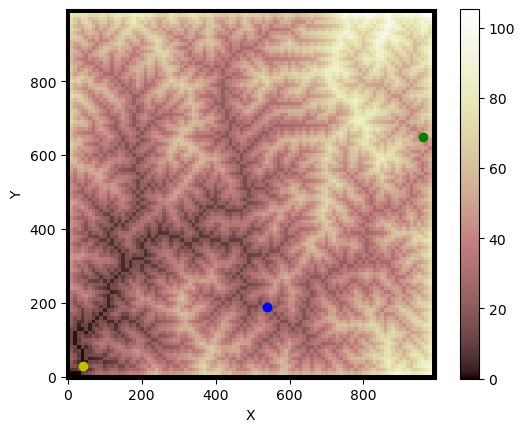

In [450]:
plt.figure(1)
imshow_grid(mg, z)  # plot the DEM
plt.plot(mg.node_x[outlet_node_to_sample], mg.node_y[outlet_node_to_sample], "yo")
plt.plot(mg.node_x[upstream_node_to_sample], mg.node_y[upstream_node_to_sample], "bo")
plt.plot(
    mg.node_x[midstream_node_to_sample], mg.node_y[midstream_node_to_sample], "go"
)

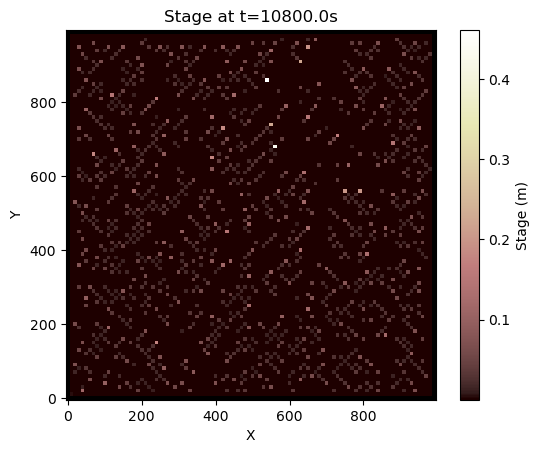

10800.7682689


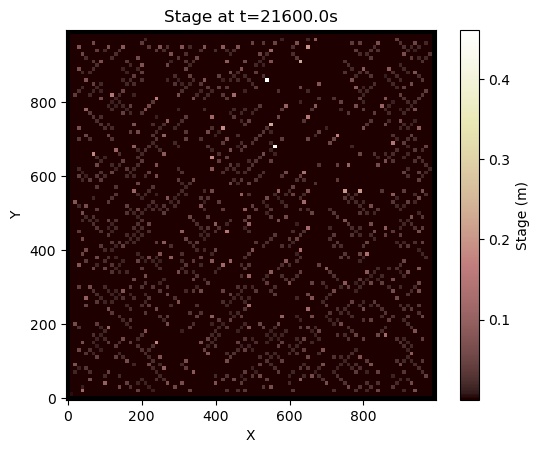

21600.3713576


In [451]:

mg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
mg.at_node['surface_water__depth'] += mg.at_node['rainfall__flux'] * storm_t
    # storm_t here is the duration of the rainfall, from the rainfall component
    # We're going to assume the rainfall arrives effectively instantaneously, but
    # adding discharge during the run is completely viable

node_of_max_q = outlet_id #this is discharge point 
outlet_depth = []
outlet_times = []
post_storm_elapsed_time = x #(s)
last_storm_loop_tracker = 1

i = 0
while post_storm_elapsed_time < of_total_time:  #time in (s)
    
    dt = of.calc_time_step()
    of.run_one_step(dt=dt)
    post_storm_elapsed_time += dt
    storm_loop_tracker = post_storm_elapsed_time % 3600.  # show every 3 min
        # NB: Do NOT allow this plotting if there are multiple files in the folder
    if storm_loop_tracker < last_storm_loop_tracker:
        #Instantiate figure as empty plot
        figelev = plt.figure()

        #Instantiate subplot as empty plot
        plot = plt.subplot()
        imshow_grid(mg,'surface_water__depth',var_name='Stage (m)')
        plt.title('Stage at t=' + str(post_storm_elapsed_time//1) + 's')
        plt.show()
        last_storm_loop_tracker = storm_loop_tracker
        outlet_depth.append(mg.at_node['surface_water__depth'][node_of_max_q])
        outlet_times.append(post_storm_elapsed_time)
        
        ## Append time and discharge to their lists to save data and for plotting.
        hydrograph_time.append(post_storm_elapsed_time)
        q = mg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * mg.dx)
        discharge_upstream.append(np.abs(q[upstream_link_to_sample]) * mg.dx)
        discharge_midstream.append(np.abs(q[midstream_link_to_sample]) * mg.dx)
        print(post_storm_elapsed_time)


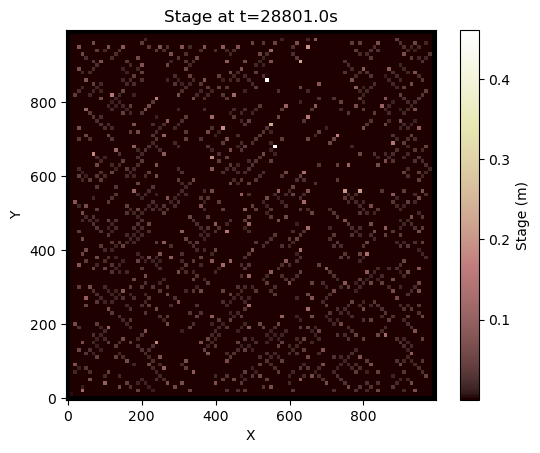

In [452]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()
imshow_grid(mg,'surface_water__depth',var_name='Stage (m)')
plt.title('Stage at t=' + str(post_storm_elapsed_time//1) + 's')
plt.show()

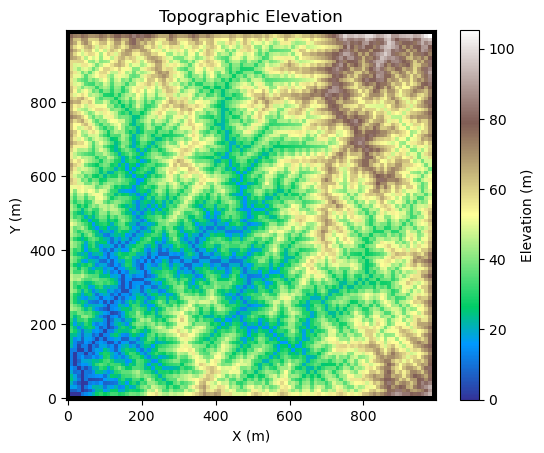

In [453]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

(0.0, 21600.371357602362, 0.0, 100.0)

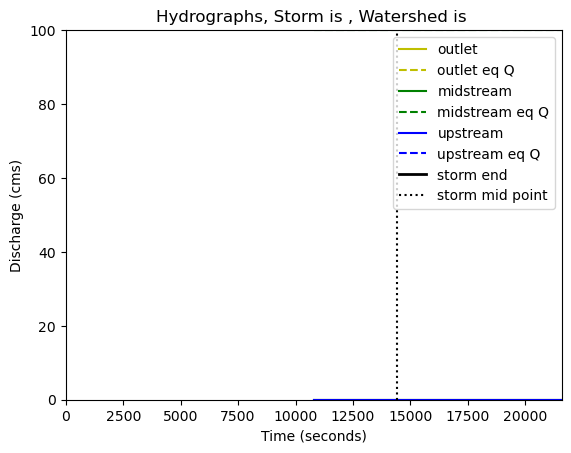

In [454]:
## Code Block 7

## Calculate equilibrium discharge at each point for reference
outlet_eq_q = mg.at_node["drainage_area"][outlet_node_to_sample]
midstream_eq_q = (
    mg.at_node["drainage_area"][midstream_node_to_sample]
)
upstream_eq_q = (
    mg.at_node["drainage_area"][upstream_node_to_sample]
)


## Plotting hydrographs and equilibrium discharge
plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "y-", label="outlet")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [outlet_eq_q, outlet_eq_q],
    "y--",
    label="outlet eq Q",
)
plt.plot(hydrograph_time, discharge_midstream, "g-", label="midstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [midstream_eq_q, midstream_eq_q],
    "g--",
    label="midstream eq Q",
)
plt.plot(hydrograph_time, discharge_upstream, "b-", label="upstream")
plt.plot(
    [np.min(hydrograph_time), np.max(hydrograph_time)],
    [upstream_eq_q, upstream_eq_q],
    "b--",
    label="upstream eq Q",
)

## Plot storm end and center of storm for reference
plt.plot(
    [of_total_time, of_total_time], [0, 100], "k-", linewidth=2, label="storm end"
)
plt.plot(
    [of_total_time / 2, of_total_time / 2], [0, 100], "k:", label="storm mid point"
)

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
title_text = "Hydrographs, Storm is " + ", Watershed is " 
plt.title(title_text)
plt.axis([0, np.max(hydrograph_time), 0, 100])